In [2]:
import matplotlib.pyplot as plt
from fabric.connection import Connection
import os
import numpy as np
from stat import S_ISDIR
import json
import string
from itertools import count
import qutip as qt
import qutip.qip.algorithms.qft as qft
from matplotlib.legend_handler import HandlerTuple, HandlerBase
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle

/home/francesco/miniconda3/envs/torch-env/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def running_mean(plot, time_window):
    num_episodes = len(plot)
    new_plot = []

    for i in range(time_window, num_episodes - time_window - 1):
        avg_value = np.mean(plot[i - time_window:i])
        new_plot.append(avg_value)

    return np.array(new_plot)

In [4]:
def running_std(plot, time_window):
    num_episodes = len(plot)
    new_plot = []

    for i in range(time_window, num_episodes - time_window - 1):
        std_value = np.std(plot[i - time_window:i])
        new_plot.append(std_value)

    return np.array(new_plot)

In [5]:
# Matplotlib advanced configuration

from cycler import cycler
import matplotlib as mpl
import palettable

SMALL_SIZE = 10
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

from matplotlib.cm import get_cmap
plt.style.use("science")

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
#colors = cmap.colors  # type: list
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#print(colors)
colors = palettable.colorbrewer.qualitative.Set2_8.mpl_colors
#print(colors)
#colors = ["deepskyblue", "darkorange", "limegreen", "coral", "violet", "sandybrown", "darkred", "darkgreen", "darkblue"]
#default_cycler = (cycler(color=colors))
#colors = []
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
#print(colors)
plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=default_cycler)
plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [6]:
def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    # for ax, lab in zip(np.ravel(ax_lst), ("(" + chr(j) + ")" for j in count(start_ord))):
    #    ax.annotate(lab, (1, 1),
    #                xytext=offset_points,
    #                xycoords='axes fraction',
    #                textcoords='offset points',
    #                ha='right', va='top', weight='bold', color="b")
    for ax, lab in zip(np.ravel(ax_lst), (r"\textbf{" + "(" + chr(j) + ")}" for j in count(start_ord))):
        ax.text(0.99, 0.08, lab, transform=ax.transAxes,
                fontsize=30, fontweight='bold', va='top', ha='right', color="black")

In [7]:
# SFTP walk through the simulation folders

def sftp_walk(files, folders, sftp, dl):
    remote_path = dl
    #print(remote_path)

    for f in sftp.listdir_attr(remote_path):
        if S_ISDIR(f.st_mode):
            if f"{dl}" not in folders:
                folders[f"{dl}"] = []
            folders[f"{dl}"].append(f.filename+"/")
            #print(dl+f.filename)
            sftp_walk(files, folders, sftp, dl + f.filename+"/")
        else:
            if f"{dl}" not in files:
                files[f"{dl}"] = []
            files[f"{dl}"].append(f.filename)

    return remote_path, files, folders

In [26]:
# Load files from folder
# Loads files from a remote folder

files_xxz_ = dict()
folders_xxz_ = dict()
files_pvqd_ = dict()
folders_pvqd_ = dict()
files_xxz_juwels = dict()
folders_xxz_juwels = dict()

T = 20
n_qubits_ucc = 4
n_points = 100
n_agents = 20
n_ep = 10000

avg_fid_xxz_ = np.zeros((n_qubits_ucc, n_points))
avg_cl_xxz_ = np.zeros((n_qubits_ucc, n_points))
best_count_density_ = np.zeros((n_qubits_ucc, n_points))
best_fid_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
mean_fid_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
std_fid_xxz_ = np.zeros((2, n_qubits_ucc, n_points))

counter_array_ = np.zeros(n_qubits_ucc, np.int16)
J_array_ = np.zeros((2, n_qubits_ucc, n_points))
Delta_array_ = np.zeros((2, n_qubits_ucc, n_points))
best_cl_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
mean_cl_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
std_cl_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
best_idx_xxz_ = np.zeros((2, n_qubits_ucc, n_points))
data_folder_xxz = "data_paper_final/data_XXZ_simulations"
delta_array = np.arange(0, 1, 20)
j_array = np.arange(0, 1, 10)
qubits_xxz = [0,1,2]

for nq in qubits_xxz:
    nq_path = f"/XXZ_{nq+3}qubits"
    for fpath in os.listdir(data_folder_xxz + nq_path):
            J = float(fpath[fpath.find("J") +2:fpath.find("Delta") -1])
            delta = float(fpath[fpath.find("Delta") + 6:fpath.find("nq=") -1])

            if delta == 0.5:
                idx = 0
            else:
                idx = 1
            fp = data_folder_xxz + nq_path + "/" + fpath

            if fpath.startswith("fidelities"):
                    #print(f_path + 'fidelities.txt')
                    a = np.loadtxt(fp).flatten()
                    max_fid = np.max(a)
                    #print("Hi", a)
                    mean_fid = np.mean(a.reshape(n_ep, 3)[-200:, :])
                    #print(mean_fid)
                    counter_array_[nq] = counter_array_[nq] + 1

                    best_idx = np.argmax(a)

                    best_idx_xxz_[idx, nq, counter_array_[nq]] = best_idx
                    best_fid_xxz_[idx, nq, counter_array_[nq]] = max_fid
                    J_array_[idx, nq, counter_array_[nq]] = J
                    Delta_array_[idx, nq, counter_array_[nq]] = delta
                    mean_fid_xxz_[idx, nq, counter_array_[nq]] = mean_fid
                    std_fid_xxz_[idx, nq, counter_array_[nq]] = np.std(a.reshape(n_ep, 3)[-200:,:])

                    cl_fp = data_folder_xxz + nq_path + "/circuit_length.txt" + fpath[14:]
                    #print(f_path + 'circuit_length.txt')

                    cl_array = np.loadtxt(cl_fp).flatten()
                    #print(cl_array.size, best_idx)
                    cl_best = cl_array[best_idx]

                    cl_mean = np.mean(cl_array[-200:])

                    best_cl_xxz_[idx, nq, counter_array_[nq]] = cl_best
                    J_array_[idx, nq, counter_array_[nq]] = J
                    Delta_array_[idx, nq, counter_array_[nq]] = delta
                    mean_cl_xxz_[idx, nq, counter_array_[nq]] = cl_mean
                    std_cl_xxz_[idx, nq, counter_array_[nq]] = np.std(cl_array.reshape(n_ep, 3)[-200:, :])

            else:
                pass



[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]
[0.99313794 0.99375238 0.99492778 0.98741758 0.99320141 0.9919166
 0.99268255 0.9917099  0.99316075 0.99239119 0.99413789 0.99268882
 0.99283566 0.99121926 0.99396186 0.99413618 0.99259534 0.99278162
 0.99217002 0.99256579]
[0.00137914 0.00187037 0.00323755 0.0809464  0.00314246 0.0016387
 0.00181172 0.0015799  0.00196419 0.00242377 0.00191663 0.00151852
 0.00269154 0.00096368 0.00166019 0.00277984 0.00336329 0.00273618
 0.00091394 0.00913079]
[0.73684211 0.78947368 1.         0.36842105 0.21052632 0.42105263
 0.47368421 0.8947

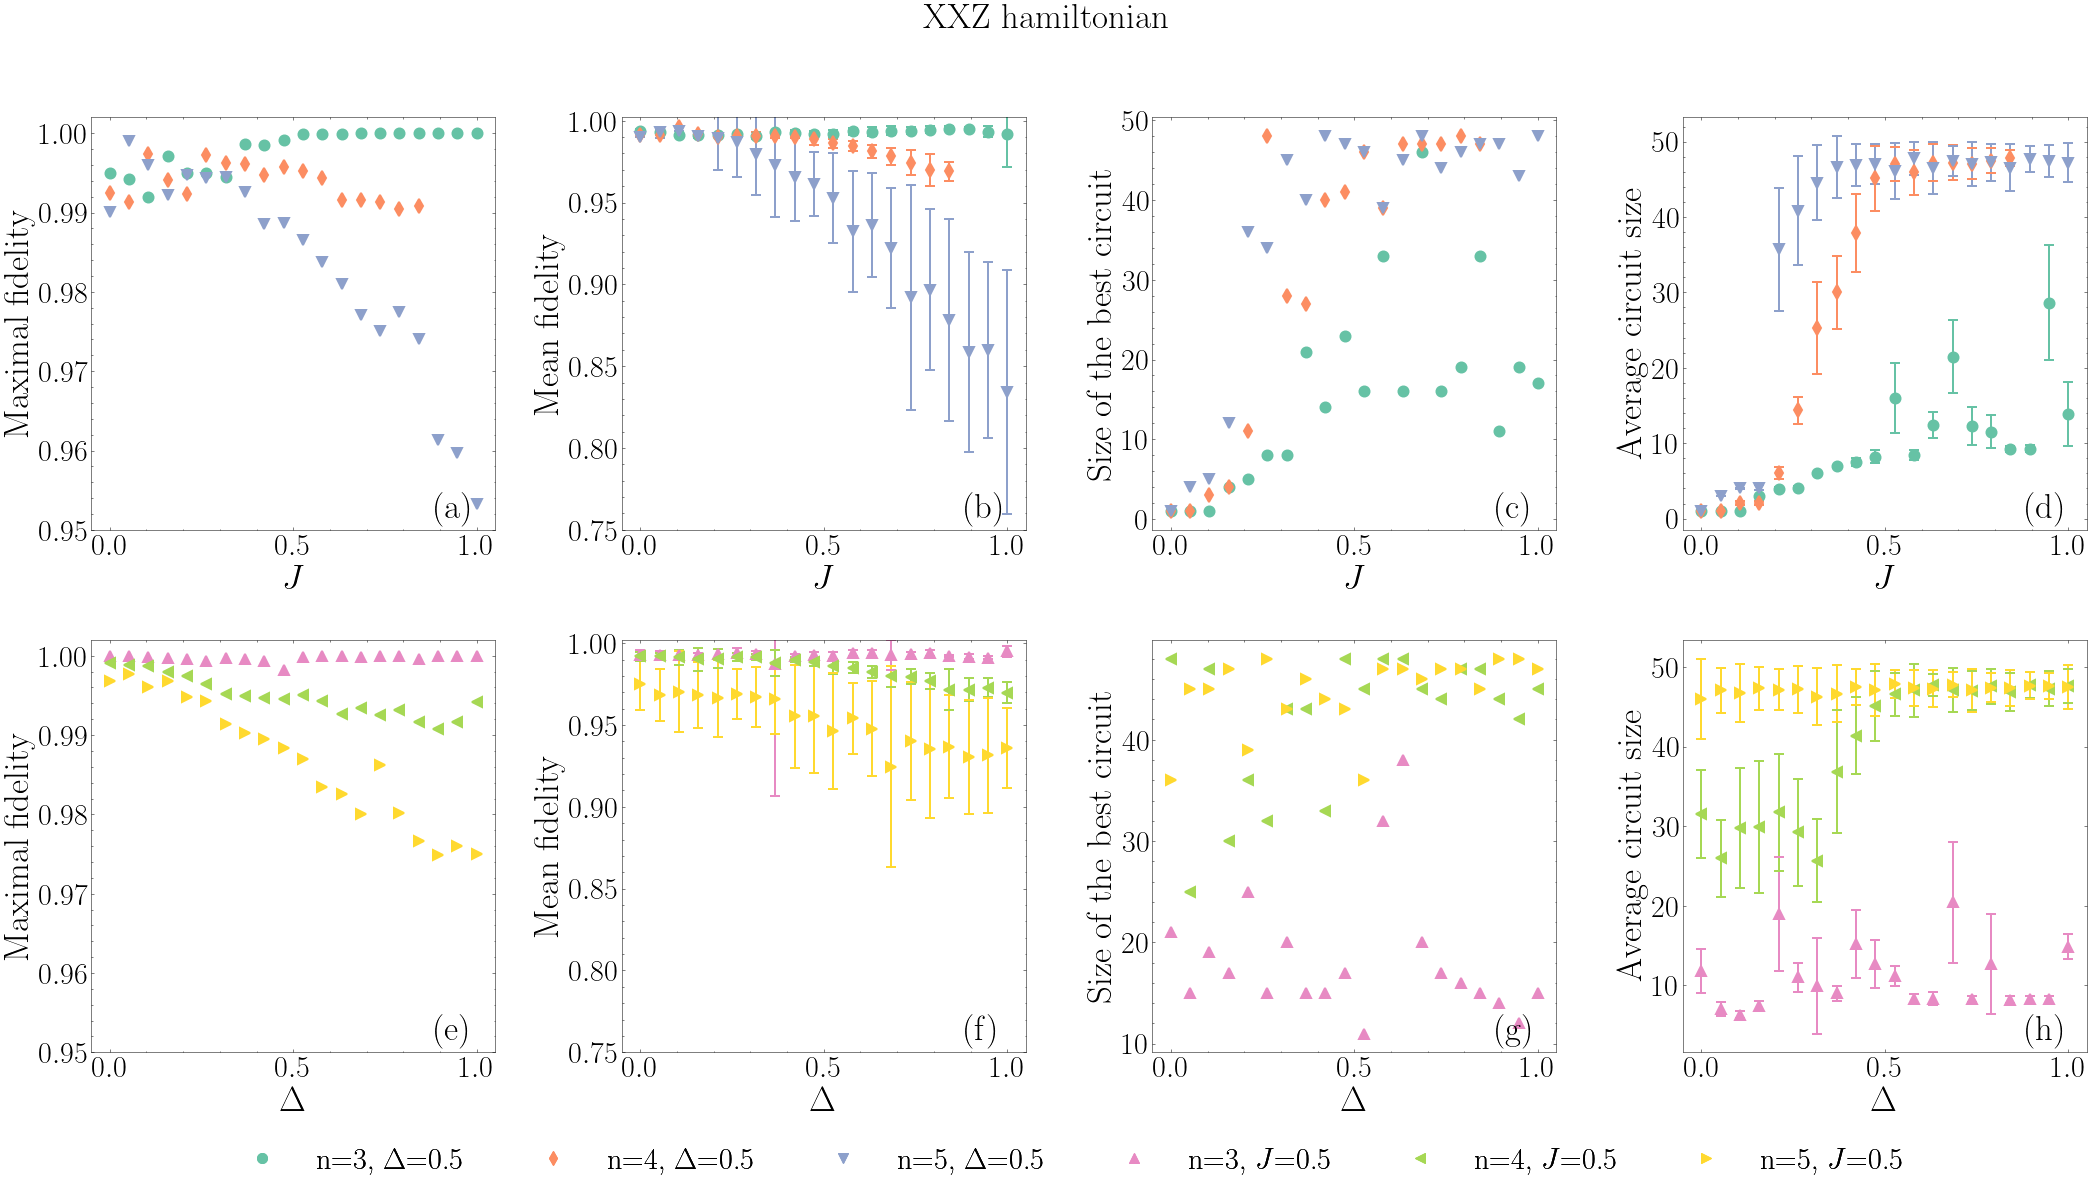

In [27]:
#
#print(mean_fid_xxz_)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30,16))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(colors)

ax1, ax2, ax3, ax4 = ax[0]
ax5, ax6, ax7, ax8 = ax[1]

fig.suptitle('XXZ hamiltonian', x=0.5, y=1.0)

names_1 = ["Maximal fidelity", "Mean fidelity",]
names_2 = ["Size of the best circuit", "Average circuit size"]
names = names_1 + names_2
#print(len(names))
labels = [r"n=3, $\Delta$=0.5", r"n=4, $\Delta$=0.5", r"n=5, $\Delta$=0.5", r"n=3, $J$=0.5", r"n=4, $J$=0.5", r"n=5, $J$=0.5"]
x_names = [r"$J$", "$\Delta$"]
markers = ["o", "d", "v", "^", "<", ">"]

msize = 10
err_config = dict(capsize=5,
    elinewidth=2,
    markeredgewidth=2)
n_q = 3

for idx in range(2):
    for i in range(3):
        filter_array = best_fid_xxz_[idx, i, :] != 0
        mean_fid_xxz_plot = mean_fid_xxz_[idx, i, :][filter_array]
        mean_cl_xxz_plot = mean_cl_xxz_[idx, i, :][filter_array]
        std_fid_xxz_plot = std_fid_xxz_[idx, i, :][filter_array]
        std_cl_xxz_plot = std_cl_xxz_[idx, i, :][filter_array]
        best_fid_xxz_plot = best_fid_xxz_[idx, i, :][filter_array]
        best_cl_xxz_plot = best_cl_xxz_[idx, i, :][filter_array]
        if idx == 0:
            x_plot = J_array_[idx, i, :][filter_array]
        else:
            x_plot = Delta_array_[idx, i, :][filter_array]
        #print(np.log(np.clip(1-best_fid_xxz_plot, 1e-12, 1)))
        ax[idx, 0].errorbar(x_plot, best_fid_xxz_plot, label=names_1[0], fmt=markers[i+n_q*idx], markersize=msize, c=colors[n_q*idx + i], **err_config)
        ax[idx, 1].errorbar(x_plot, mean_fid_xxz_plot, label=names_1[1], fmt=markers[i+n_q*idx],  markersize=msize, c=colors[n_q*idx + i], yerr=std_fid_xxz_plot,
                            **err_config)
        if idx == 1 and i==0:
            print(mean_fid_xxz_plot)
            print(std_fid_xxz_plot)
            print(x_plot)
        ax[idx, 2].errorbar(x_plot, best_cl_xxz_plot, label=names_2[0], fmt=markers[i+n_q*idx], markersize=msize, c=colors[n_q*idx + i],**err_config)
        ax[idx, 3].errorbar(x_plot, mean_cl_xxz_plot, label=names_2[1], fmt=markers[i+n_q*idx], markersize=msize, c=colors[n_q*idx + i], yerr=std_cl_xxz_plot,
                            **err_config)

#ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax5.set_yscale('log')
#ax6.set_yscale('log')
ax1.set_ylim(0.95, 1.002)
ax2.set_ylim(0.75, 1.002)
ax5.set_ylim(0.95, 1.002)
ax6.set_ylim(0.75, 1.002)

for i_a, a in enumerate(ax.flatten()):
    a.set_xlabel(x_names[i_a // 4])
    a.set_ylabel(names[i_a % 4])
    a.text(0.85, 0.03, "(" + string.ascii_lowercase[i_a] + ")", transform=a.transAxes,
            size=BIGGER_SIZE, fontweight='bold')

l_styles = ('solid', 'solid', 'dashed')
legend_elements = [Line2D([0], [0], c=colors[i], label=labels[i], marker=markers[i], linestyle='None', markersize=10) for i in range(6)]
kw1 = dict(ncol=6, loc="upper center", frameon=False, fancybox=True, shadow=True)

leg1 = fig.legend(handles=legend_elements, bbox_to_anchor=(0.51, 0.03), **kw1)
plt.minorticks_off()

# leg2 = fig.legend(new_lines[3:], new_labels[3:], bbox_to_anchor=(0.51, -0.02), **kw2)
fig.add_artist(leg1)

fig.tight_layout()
plt.savefig(os.path.join("data_paper_final", "xxz_hamiltonian_analysis.pdf"), dpi=300,
                format='pdf',
                bbox_inches='tight')

plt.show()

In [15]:
def select_best_sequences(seq_data_list, fid_list, cl_arr):
    best_fid_idx = (1 - np.asarray(fid_list) < 1e-2).flatten()
    #print(best_fid_idx.shape[0])
    #print(np.asarray(seq_data_list[:-1]).shape[0])
    best_sequences = list(np.asarray(seq_data_list[:-1])[best_fid_idx])
    best_fidelities = fid_list.flatten()[best_fid_idx]
    best_circuit_length = cl_arr.flatten()[best_fid_idx]

    return best_sequences, best_fidelities, best_circuit_length



In [10]:
gate_comp_folder = os.path.join("data_paper-final/data_Toffoli_simulations/toffoli_3_pslstm_2")
with open(os.path.join(gate_comp_folder,'sequences.txt'), 'r') as f:
        seq_data_toffoli3 = f.read().split("\n")
toffoli3_fid = np.loadtxt(os.path.join(gate_comp_folder, "fidelities.txt"))
toffoli3_cl = np.loadtxt(os.path.join(gate_comp_folder, "circuit_length.txt"))
angles_toffoli3 = np.loadtxt(os.path.join(gate_comp_folder, "angle_params.txt"))

gate_comp_folder = os.path.join("data_paper-final/data_Toffoli_simulations/toffoli_4_pslstm")
with open(os.path.join(gate_comp_folder,'sequences.txt'), 'r') as f:
        seq_data_toffoli4 = f.read().split("\n")
toffoli4_fid = np.loadtxt(os.path.join(gate_comp_folder, "fidelities.txt"))
toffoli4_cl = np.loadtxt(os.path.join(gate_comp_folder, "circuit_length.txt"))

(5, 10000)
[[ 0. 22. 17. ... 10. 10. 10.]
 [ 0. 28. 28. ... 19. 19. 19.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(10, 19)


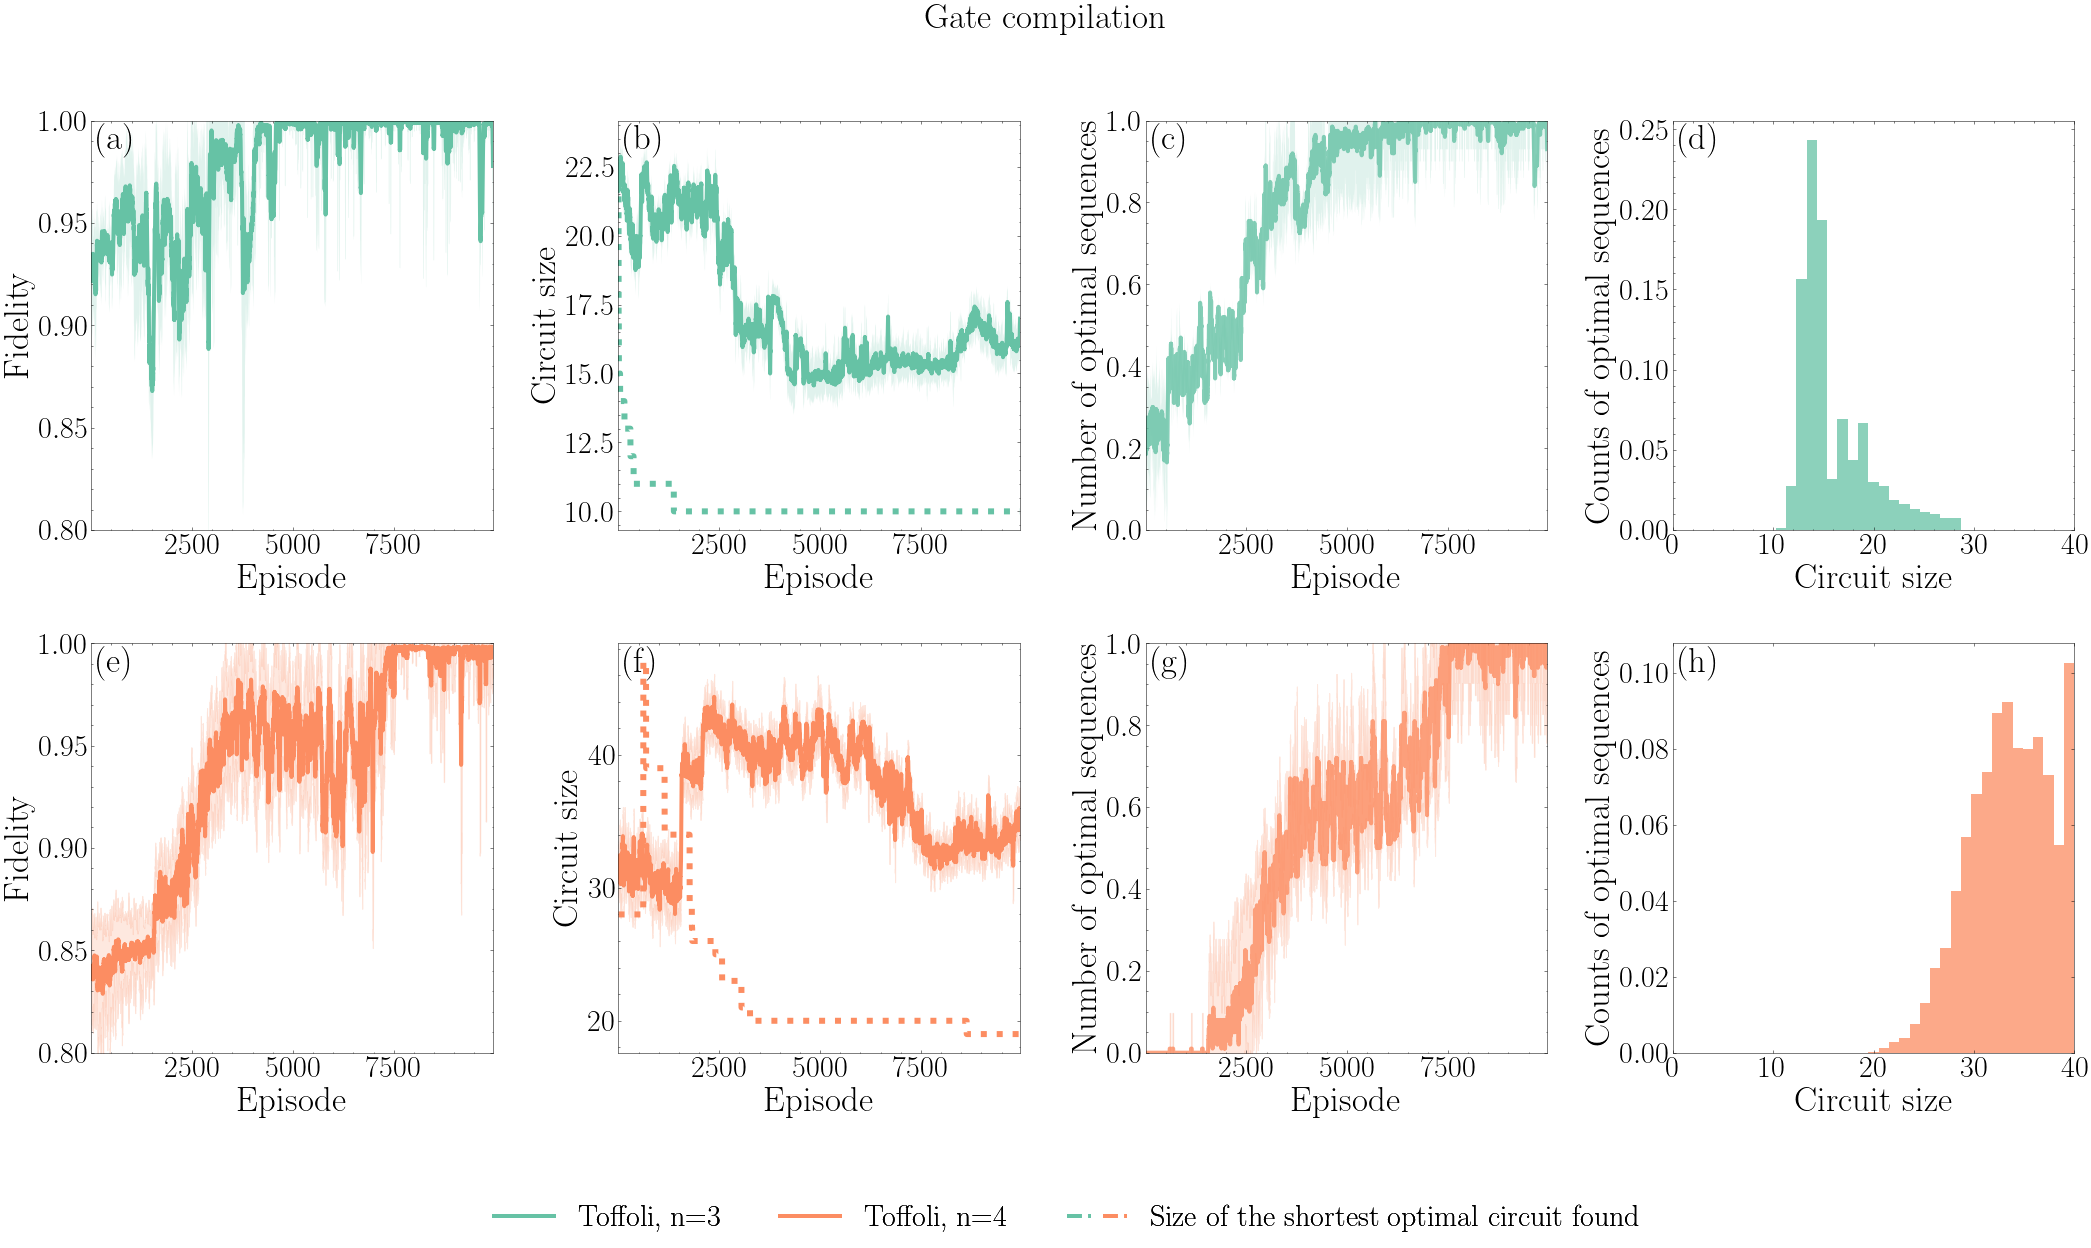

In [47]:
# Toffoli gate with 3 and 4 qubits

n_lines = 3
n_episodes = 10000
T = 20
fidelity_plot = np.zeros((n_lines, n_episodes))
cl_plot = np.zeros((n_lines, n_episodes))
best_count_plot = np.zeros((n_lines, n_episodes))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fidelity_std = np.zeros((n_lines, n_episodes))
cl_std = np.zeros((n_lines, n_episodes))
best_count_std = np.zeros((n_lines, n_episodes))

fidelity_plot[0, :toffoli3_fid.shape[1] - 2*T - 1] = running_mean(np.mean(toffoli3_fid, axis=0), T)
best_count_plot[0, :toffoli3_fid.shape[1] - 2*T - 1] = running_mean(np.mean(toffoli3_fid > 0.99, axis=0), T)
cl_plot[0,:toffoli3_fid.shape[1]- 2*T - 1] = running_mean(np.mean(toffoli3_cl, axis=0),T)

fidelity_std[0, :toffoli3_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli3_fid, axis=0), T)
cl_std[0, :toffoli3_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli3_cl, axis=0), T)
best_count_std[0, :toffoli3_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli3_fid > 0.99, axis=0), T)

best_sequences_toffoli3, *_ = select_best_sequences(seq_data_toffoli3, toffoli3_fid, toffoli3_cl)

print(toffoli4_fid.shape)
fidelity_plot[1, :toffoli4_fid.shape[1]- 2*T - 1] = running_mean(np.mean(toffoli4_fid, axis=0), T)
cl_plot[1,:toffoli4_fid.shape[1]- 2*T - 1] = running_mean(np.mean(toffoli4_cl, axis=0), T)
best_count_plot[1, :toffoli4_fid.shape[1]- 2*T - 1] = running_mean(np.mean(toffoli4_fid > 0.99,axis=0), T)

fidelity_std[1, :toffoli4_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli4_fid, axis=0), T)
cl_std[1, :toffoli4_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli4_cl, axis=0), T)
best_count_std[1, :toffoli4_fid.shape[1] - 2*T - 1] = running_std(np.std(toffoli4_fid > 0.99, axis=0), T)

best_sequences_toffoli4, *_ = select_best_sequences(seq_data_toffoli4, toffoli4_fid, toffoli4_cl)


# Best length plot
cl_best_plot = np.zeros((n_lines, n_episodes))
for i in range(1, toffoli3_cl.shape[1]):
    #print(toffoli3_cl[:, :i])
    toff_cl_loc = toffoli3_cl[:, :i]
    count_loc = (toffoli3_fid > 0.99)[:, :i]
    try:
        cl_best_plot[0, i] = np.min(toff_cl_loc[count_loc])
    except ValueError:
        cl_best_plot[0, i] = 38

for i in range(1, toffoli4_cl.shape[1]):
    toff_cl_loc = toffoli4_cl[:, :i]
    count_loc = (toffoli4_fid > 0.99)[:, :i]
    try:
        cl_best_plot[1, i] = np.min(toff_cl_loc[count_loc])
    except ValueError:
        cl_best_plot[1, i] = 28

print(cl_best_plot)
#gate_comp_folder = os.path.join("/media/francesco/BACKUP/data_rl_Toffoli/data12_01_2022_02_05_52")
#with open(os.path.join(gate_comp_folder,'sequences.txt'), 'r') as f:
#        seq_data_qft3 = f.read().split("\n")
#qft3_fid = np.loadtxt(os.path.join(gate_comp_folder, "fidelities.txt"))
#qft3_cl = np.loadtxt(os.path.join(gate_comp_folder, "circuit_length.txt"))
#fidelity_plot[2, :qft3_fid.shape[0]- 2*T - 1] = running_mean(qft3_fid, T)
#cl_plot[2,:qft3_fid.shape[0]- 2*T - 1] = running_mean(qft3_cl, T)
#best_count_plot[2, :qft3_fid.shape[0]- 2*T - 1] = running_mean(qft3_fid > 0.99, T)
#best_sequences_qft3, *_ = select_best_sequences(seq_data_qft3, qft3_fid, qft3_cl)

# Import and analise all sequences to build statistics

all_best_seq = (best_sequences_toffoli3, best_sequences_toffoli4)
#print(best_sequences_toffoli3[0].split("-"))

best_length_t3 = list(map(lambda x: len(x.split("-")), best_sequences_toffoli3))
best_length_t4 = list(map(lambda x: len(x.split("-")), best_sequences_toffoli4))
#best_length_qft3 = list(map(lambda x: len(x.split("-")), best_sequences_qft3))
best_length = [best_length_t3, best_length_t4]
res_min = min(best_length_t3), min(best_length_t4)
print(res_min)
# print(toffoli3_fid.flatten()[np.argmin(best_length_t3)])
#print(angles_toffoli3.flatten()[np.argmin(best_length_t3)])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 16))

fig.suptitle('Gate compilation', x=0.5, y=1.0)
start = 1
nep_1 = 10000 - 2*T - 1
x_ax1 = np.arange(start + 1, nep_1 + 2)

labels = ["Toffoli, n=3", "Toffoli, n=4", "Size of the shortest optimal circuit found"]#, "QFT, n=3 ", "QFT, n=4"]


ax[0,0].plot(x_ax1, fidelity_plot[0,:nep_1].T, c=colors[0])
ax[0,0].fill_between(x_ax1, fidelity_plot[0,:nep_1].T - fidelity_std[0,:nep_1].T, fidelity_plot[0,:nep_1].T + fidelity_std[0,:nep_1].T, alpha=0.2)
ax[0,0].set_xlabel("Episode")
ax[0,0].set_ylabel("Fidelity")
#ax1.set_yscale("log")
ax[0,0].set_xlim(start, nep_1)
ax[0,0].set_ylim(0.8, 1)

ax[0,1].plot(x_ax1, cl_plot[0,:nep_1].T, c=colors[0])
ax[0,1].fill_between(x_ax1, cl_plot[0,:nep_1].T - cl_std[0,:nep_1].T, cl_plot[0,:nep_1].T + cl_std[0,:nep_1].T, alpha=0.2)
ax[0,1].set_xlabel("Episode")
ax[0,1].set_ylabel("Circuit size")
ax[0,1].set_xlim(start, nep_1)
#ax[0,1].hlines(y=10, xmin = x_ax1[0], xmax = x_ax1[-1],  linewidth=6, linestyles="dotted", colors=colors[2])
ax[0,1].plot(x_ax1, cl_best_plot[0,1:nep_1+1].T, c=colors[0], linestyle="dotted", linewidth=6)

#ax2.set_ylim(0, 38)

ax[0,2].plot(x_ax1, best_count_plot[0,:nep_1].T, alpha=0.8, c=colors[0])
ax[0,2].fill_between(x_ax1, best_count_plot[0,:nep_1].T - best_count_std[0,:nep_1].T, best_count_plot[0,:nep_1].T + best_count_std[0,:nep_1].T, alpha=0.2)
ax[0,2].set_xlabel("Episode")
ax[0,2].set_ylabel("Number of optimal sequences")
ax[0,2].set_xlim(start, nep_1)
ax[0,2].set_ylim(0, 1)

bins = np.linspace(0, 40, 40)
n, bins, patches = ax[0,3].hist(best_length[0], bins, density=True, alpha=0.75, color=colors[0])
nep_2 = 10000 - 2*T - 1
x_ax = np.arange(start + 1, nep_2 + 2)
ax[1,0].plot(x_ax, fidelity_plot[1,:nep_2].T, c=colors[1])
ax[1,0].fill_between(x_ax, fidelity_plot[1,:nep_2].T - fidelity_std[1,:nep_2].T, fidelity_plot[1,:nep_2].T + fidelity_std[1,:nep_2].T, alpha=0.2, color=colors[1])
ax[1,0].set_xlabel("Episode")
ax[1,0].set_ylabel("Fidelity")
#ax1.set_yscale("log")
ax[1,0].set_xlim(start, nep_2)
ax[1,0].set_ylim(0.8, 1)


ax[1,1].plot(x_ax, cl_plot[1,:nep_2].T, c=colors[1])
ax[1,1].fill_between(x_ax, cl_plot[1,:nep_2].T - cl_std[1,:nep_2].T, cl_plot[1,:nep_2].T + cl_std[1,:nep_2].T, alpha=0.2, color=colors[1])
ax[1,1].set_xlabel("Episode")
ax[1,1].set_ylabel("Circuit size")
ax[1,1].set_xlim(start, nep_2)
#ax[1,1].hlines(y=19, xmin = x_ax[0], xmax = x_ax[-1], linewidth=6, linestyles="dotted", colors=colors[2])
ax[1,1].plot(x_ax1, cl_best_plot[1,1:nep_1+1].T, c=colors[1], linestyle="dotted", linewidth=6)
ax[1,2].set_ylim(0, 38)

ax[1,2].plot(x_ax, best_count_plot[1,:nep_2].T, alpha=0.8, c=colors[1])
ax[1,2].fill_between(x_ax, best_count_plot[1,:nep_2].T - best_count_std[1,:nep_2].T, best_count_plot[1,:nep_2].T + best_count_std[1,:nep_2].T, alpha=0.2, color=colors[1])
ax[1,2].set_xlabel("Episode")
ax[1,2].set_ylabel("Number of optimal sequences")
ax[1,2].set_xlim(start, nep_2)
ax[1,2].set_ylim(0, 1)

for i_q in range(n_lines-2):
    #print(best_seq_loaded[str(i_q+3)][0:20])
    n, bins, patches = ax[1,3].hist(best_length[i_q+1], bins, density=True, alpha=0.75, color=colors[1])

for i in range(2):
    ax[i,3].set_xlabel("Circuit size")
    ax[i,3].set_ylabel("Counts of optimal sequences")
    ax[i,3].set_xlim(0, 40)

for i_a, a in enumerate(ax.flatten()):
    a.text(0.015, 0.93, "(" + string.ascii_lowercase[i_a] + ")", transform=a.transAxes,
            size=BIGGER_SIZE, weight='bold')


l_styles = ('solid', 'solid', 'dashed')
legend_elements = [Line2D([0], [0], color=colors[0], label=labels[0], linestyle=l_styles[0]), Line2D([0], [0], color=colors[1], label=labels[1], linestyle=l_styles[1]),
                   (Line2D([0], [0], color=colors[0], label="Shortest optimal sequence found", linestyle=l_styles[2]), Line2D([0], [0], color=colors[1], label="Shortest optimal sequence found", linestyle=l_styles[2]))]
kw1 = dict(ncol=4, loc="upper center", frameon=False, fancybox=True, shadow=True)

leg1 = fig.legend(handles=legend_elements, labels=labels, handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0.51, -0.02), **kw1)
plt.minorticks_off()

#leg2 = fig.legend(new_lines[3:], new_labels[3:], bbox_to_anchor=(0.51, -0.02), **kw2)
fig.add_artist(leg1)

fig.tight_layout()
plt.savefig(os.path.join("plots_paper", "Gate_compilation.pdf"), dpi=300,
                format='pdf',
                bbox_inches='tight')
plt.show()


In [11]:
T = 20
n_qubits_ucc = 6
n_episodes = 10000 - 2*T - 1
n_agents = 20

avg_fid_ucc = np.zeros((n_qubits_ucc, n_episodes))
avg_cl_ucc = np.zeros((n_qubits_ucc, n_episodes))
best_count_density = np.zeros((n_qubits_ucc, n_episodes))
best_fid_ucc = np.zeros((n_qubits_ucc, n_episodes))

std_fid_ucc = np.zeros((n_qubits_ucc, n_episodes))
std_cl_ucc = np.zeros((n_qubits_ucc, n_episodes))
std_count_density = np.zeros((n_qubits_ucc, n_episodes))
cl_best_plot = np.zeros((n_qubits_ucc, n_episodes + 2*T + 1))

#list_subfolders_with_paths = [f.path for f in os.scandir(data_folder_path) if f.is_dir()]
#print(len(list_subfolders_with_paths))
b1, b2, b3, b4, b5, b6, b7 = [], [], [], [], [], [], []
data_folder_ucc = "data_paper_final/data_UCC_simulations"
qubits_ucc = range(0, n_qubits_ucc)
print(list(qubits_ucc))

for nq in qubits_ucc:
    nq_path = f"/UCC_{nq+3}qubits"
    for fpath in os.listdir(data_folder_ucc + nq_path):
            nq = int(fpath[fpath.find("nq") + 3:fpath.find("qubits")]) - 3
            #delta = float(fpath[fpath.find("Delta") + 6:fpath.find("nq=") -1])

            fp = data_folder_ucc + nq_path + "/" + fpath
            print(nq)

            if fpath.startswith("fidelities"):
                fid_array = np.loadtxt(fp)
                #print(fid_array.shape)

                cl_fp = data_folder_ucc + nq_path + "/circuit_length.txt" + fpath[14:]
                seq_fp = data_folder_ucc + nq_path + "/sequences.txt" + fpath[14:]
                arg_fp = data_folder_ucc + nq_path + "/commandline_args.txt" + fpath[14:]
                best_seq_fp = data_folder_ucc + nq_path + "/best_sequences.txt" + fpath[14:]

                circ_length = np.loadtxt(cl_fp)

                with open(os.path.join(arg_fp), 'r') as f:
                    #print(f.read())
                    data = f.read().split(r"}")[0] + "}"
                    arg_dict = dict(json.loads(data))
                    seed = arg_dict["seed"]
                    print(arg_dict["seed"])

                best_fid_counts = running_mean(fid_array > 0.99, T)
                #print(running_mean(fid_array/n_agents, T))
                avg_fid_ucc[nq, :] += running_mean(fid_array, T)/n_agents
                print(avg_fid_ucc[nq, :])
                avg_cl_ucc[nq, :] += running_mean(circ_length, T)[:n_episodes]/n_agents
                best_count_density[nq, :] += np.array(best_fid_counts)/n_agents

                std_fid_ucc[nq, :] += running_std(fid_array, T)/n_agents
                std_cl_ucc[nq, :] += running_std(circ_length, T)[:n_episodes]/n_agents
                std_count_density[nq, :] += np.array(running_std(fid_array > 0.99, T))/n_agents

                for i in range(1, fid_array.shape[0]):
                    #print(toffoli3_cl[:, :i])
                    ucc_cl_loc = circ_length[:i]
                    ucc_count_loc = (fid_array > 0.99)[:i]
                    try:
                        cl_best_plot[nq, i] = np.min(ucc_cl_loc[ucc_count_loc])
                    except ValueError:
                        cl_best_plot[nq, i] = arg_dict["len_seq"] - 2


                idx_list = np.where(fid_array > 0.99)
                seq = [circ_length[idx] for idx in idx_list]
                            #print(seq)

                if nq == 0:
                    b1 += seq
                elif nq == 1:
                    b2 += seq
                elif nq == 2:
                    b3 += seq
                elif nq == 3:
                    b4 += seq
                elif nq == 4:
                    b5 += seq
                elif nq == 5:
                    b6 += seq
                elif nq == 6:
                    b7 += seq
                else:
                    raise ValueError("nq = {}".format(nq))

[0, 1, 2, 3, 4, 5]
0
0
0
0
0
9
[0.03625978 0.03625978 0.03698741 ... 0.04996573 0.0499633  0.0499631 ]
0
0
0
0
0
0
14
[0.07251956 0.07251956 0.07397482 ... 0.09990534 0.09990291 0.09990272]
0
5
[0.10877933 0.10877933 0.11096223 ... 0.14984881 0.14984639 0.14986185]
0
0
0
0
0
0
0
0
0
4
[0.14503911 0.14503911 0.14794965 ... 0.19976474 0.19976232 0.19977777]
0
13
[0.18129889 0.18129889 0.18493706 ... 0.24967189 0.24966947 0.24968625]
0
19
[0.21755867 0.21755867 0.22192447 ... 0.29957072 0.29958379 0.29960057]
0
0
18
[0.25381845 0.25381845 0.25891188 ... 0.34950963 0.3495292  0.34955219]
0
0
11
[0.29007822 0.29007822 0.29589929 ... 0.39947738 0.39947697 0.39951573]
0
0
0
0
0
0
0
1
[0.326338   0.326338   0.3328867  ... 0.44938454 0.44938413 0.4494229 ]
0
16
[0.36259778 0.36259778 0.36987411 ... 0.49932814 0.49932961 0.49937012]
0
0
0
0
0
0
0
0
17
[0.39885756 0.39885756 0.40686153 ... 0.54924263 0.54924413 0.54928605]
0
0
0
0
15
[0.43511734 0.43511734 0.44384894 ... 0.59918451 0.59919843 0.5

[0.66369086 0.65864645 0.65204089 ... 0.99876311 0.99875922 0.99884776]
[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


RuntimeError: Failed to process string with tex because dvipng could not be found

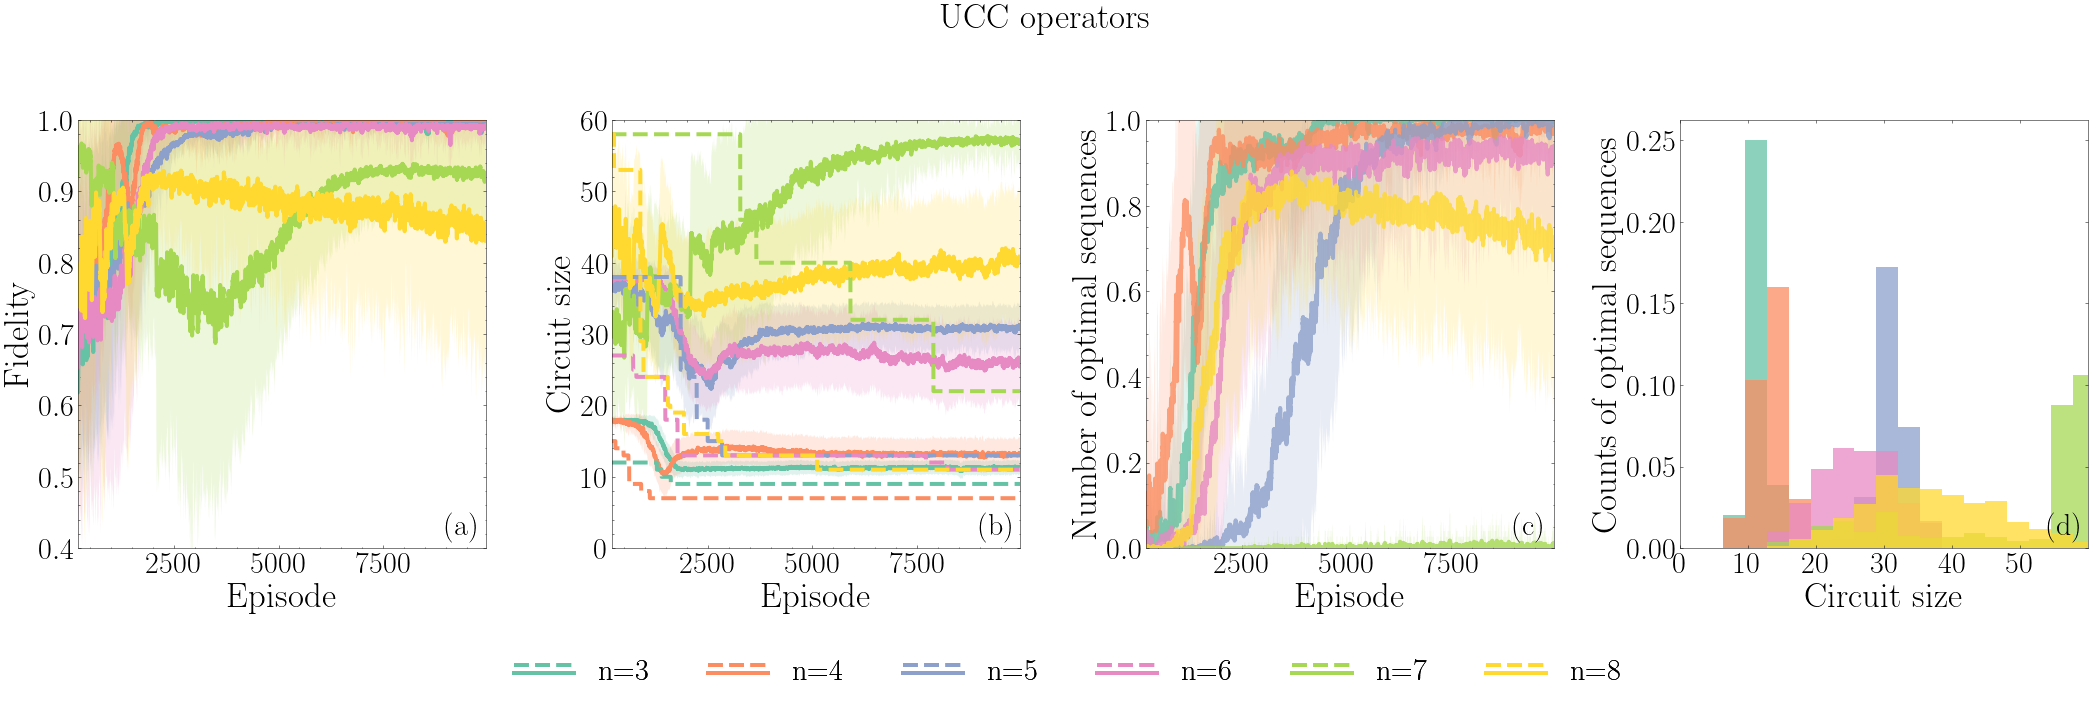

In [12]:
# Plot UCC operators
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0], linestyle="dashed")
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height],
                           color=orig_handle[1])
        return [l1, l2]


#best_seq_loaded = list(dict.fromkeys(best_seq_loaded))
#print(b7)
best_length = []

for b in (b1, b2, b3, b4, b5, b6):
    s = []
    for el_b in b:
        s += list(el_b)
    best_length.append(s)

#best_length += b5
#best_length += b6
#print(best_length[0])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(30, 9))
fig.patch.set_facecolor('white')
ax = (ax1, ax2, ax3, ax4)
fig.suptitle('UCC operators', x=0.5, y=1.0)
start = 200
x_ax = np.arange(start + 1, n_episodes + 1)
labels = ["n=3", "n=4", "n=5", "n=6", "n=7", "n=8"]

ax1.plot(x_ax, avg_fid_ucc[:,start:].T)
print(avg_fid_ucc[0, start:])
for i_q in range(n_qubits_ucc):
    ax1.fill_between(x_ax, avg_fid_ucc[i_q, start:] - std_fid_ucc[i_q, start:],
                     avg_fid_ucc[i_q, start:] + std_fid_ucc[i_q, start:], alpha=0.2)
#ax1.fill_between(x_ax, avg_fid_ucc[:,start:].T - std_fid_ucc[:,start:].T, avg_fid_ucc[:,start:].T + std_fid_ucc[:,start:].T, alpha=0.2)
ax1.set_xlabel("Episode")
ax1.set_ylabel("Fidelity")
ax1.set_xlim(start, n_episodes)
ax1.set_ylim(0.4, 1)

ax2.plot(x_ax, avg_cl_ucc[:,start:].T)
for i_q in range(n_qubits_ucc):
    ax2.fill_between(x_ax, avg_cl_ucc[i_q, start:] - std_cl_ucc[i_q, start:],
                     avg_cl_ucc[i_q, start:] + std_cl_ucc[i_q, start:], alpha=0.2)
#ax2.fill_between(x_ax, avg_cl_ucc[:,start:].T - std_cl_ucc[:,start:].T, avg_cl_ucc[:,start:].T + std_cl_ucc[:,start:].T, alpha=0.2)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Circuit size")
ax2.set_xlim(start, n_episodes)
print(colors)
for i_q in range(n_qubits_ucc):
    ax2.plot(x_ax, cl_best_plot[i_q,start:n_episodes].T, linestyle="dashed", c=colors[i_q])
ax2.set_ylim(0, 60)

ax3.plot(x_ax, best_count_density[:,start:].T, alpha=0.8)
for i_q in range(n_qubits_ucc):
    ax3.fill_between(x_ax, best_count_density[i_q, start:] - std_count_density[i_q, start:],
                     best_count_density[i_q, start:] + std_count_density[i_q, start:], alpha=0.2)
#ax3.fill_between(x_ax, best_count_density[:,start:].T - std_count_density[:,start:].T, best_count_density[:,start:].T + std_count_density[:,start:].T, alpha=0.2)
ax3.set_xlabel("Episode")
ax3.set_ylabel("Number of optimal sequences")
ax3.set_xlim(start, n_episodes)
ax3.set_ylim(0, 1)

bins = np.linspace(0, 61, 20)

for i_q in range(n_qubits_ucc):
    #print(best_seq_loaded[str(i_q+3)][0:20])
        n, bins, patches = ax4.hist(best_length[i_q], bins, density=True, alpha=0.75)

ax4.set(xticks=range(0, 60, 10), xlim=[0, 60])
ax4.set_xlabel("Circuit size")
ax4.set_ylabel("Counts of optimal sequences")

for i_a, a in enumerate(ax):
    a.text(0.9, 0.03, "(" + string.ascii_lowercase[i_a] + ")", transform=a.transAxes,
            size=MEDIUM_SIZE, weight='bold')

kw1 = dict(ncol=6, loc="upper center", frameon=False, fancybox=True, shadow=True)
# kw2 = dict(ncol=2, loc="upper center", frameon=False, fancybox=True, shadow=True)
leg1 = fig.legend([(colors[i], colors[i]) for i in range(n_qubits_ucc)], labels, bbox_to_anchor=(0.51, 0.03), handler_map={tuple: AnyObjectHandler()}, **kw1)

fig.add_artist(leg1)

leg1.legendHandles[0]._sizes = [15]
# leg2.legendHandles[1]._sizes = [15]

plt.minorticks_off()

fig.tight_layout()
plt.savefig(os.path.join("data_paper_final", "UCC_operators.pdf"), dpi=300,
                format='pdf',
                bbox_inches='tight')
plt.show()

[50.]
(4, 1, 9)
[50.]
[6. 7.]
[3.59880924e-04 5.97608089e-04 3.93612385e-03 1.43306613e-02
 7.09129810e-02 1.65350449e-01 7.00401390e-01 3.16860108e+00
 1.73642567e+01]
[7.91988472e-06 4.39636603e-06 3.37619780e-05 1.20600019e-04
 2.24169911e-03 2.02531173e-03 6.91148802e-03 2.10207232e-02
 7.71289178e-02]


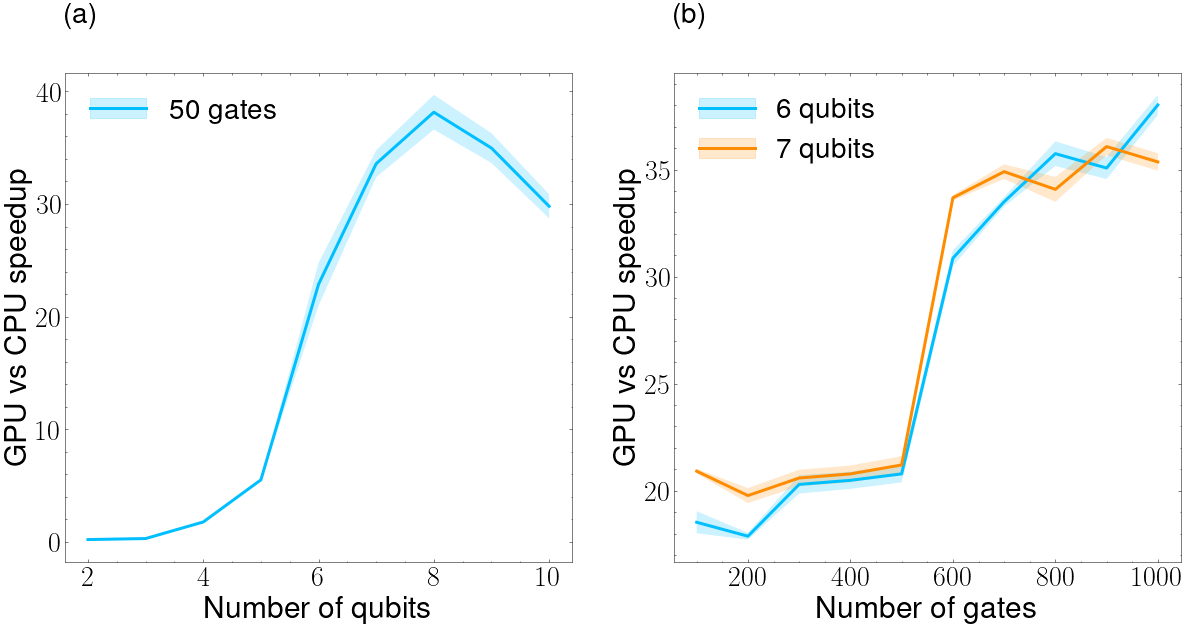

In [29]:
# Runtime plots for gradients

import numpy as np
import string
import matplotlib.pyplot as plt
from iplots import *

SMALL_SIZE = 10
MEDIUM_SIZE = 28
BIGGER_SIZE = 30

#plt.style.use("science")
alphas = np.array([0.2])
plt.rc('lines', linewidth=3)
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

fig, axes = plt.subplots(1, 2, figsize=(20,9))
ax1, ax2 = axes

for i_a, a in enumerate(axes):
        a.text(0.0, 1.10, "(" + string.ascii_lowercase[i_a] + ")", transform=a.transAxes,
               size=MEDIUM_SIZE, weight='bold')


n_qubits_arr_1 = np.loadtxt(os.path.join(os.getcwd(), "plots_paper", "n_qubits_array_1.txt"))
n_qubits_arr_2 = np.loadtxt(os.path.join(os.getcwd(),"plots_paper", "n_qubits_array_2.txt"))
n_gates_arr_1 = np.array([np.loadtxt(os.path.join(os.getcwd(),"plots_paper", "n_gates_array_1.txt")),])
n_gates_arr_2 = np.loadtxt(os.path.join(os.getcwd(), "plots_paper", "n_gates_array_2.txt"))
print(n_gates_arr_1)
t_arr_qubits = np.loadtxt(os.path.join("plots_paper","t_arr_qubits.txt")).reshape(4, len(n_gates_arr_1), len(n_qubits_arr_1))
t_arr_circuit = np.loadtxt(os.path.join("plots_paper","t_arr_circuit.txt")).reshape(4, len(n_gates_arr_2), len(n_qubits_arr_2))
t_arr_circuit_cpu = np.loadtxt(os.path.join("plots_paper","t_arr_circuit_cpu.txt")).reshape(4, len(n_gates_arr_2), len(n_qubits_arr_2))
t_arr_qubits_cpu = np.loadtxt(os.path.join("plots_paper","t_arr_qubits_cpu.txt")).reshape(4, len(n_gates_arr_1), len(n_qubits_arr_1))

#print(t_arr_circuit)

print(t_arr_qubits.shape)
print(n_gates_arr_1)
print(n_qubits_arr_2)
res_to_plot_qubits = (50, )
res_to_plot_circuit = (6, 7,)
legendary = []
for i, ng in enumerate(n_gates_arr_1):
    print(t_arr_qubits_cpu[0, i, :])
    print(t_arr_qubits_cpu[2, i, :])
    if int(ng) in res_to_plot_qubits:
        std_dev_jax=np.sqrt((t_arr_qubits_cpu[2, i, :]/ t_arr_qubits_cpu[0, i, :])**2 + (t_arr_qubits[2, i, :]/t_arr_qubits[0, i, :])**2)*t_arr_qubits_cpu[0, i, :]/t_arr_qubits[0, i, :]
        std_dev_numba_jax = np.sqrt((t_arr_qubits[3, i, :]/ t_arr_qubits[1, i, :])**2 + (t_arr_qubits[2, i, :]/t_arr_qubits[0, i, :])**2)*t_arr_qubits[1,i, :]/t_arr_qubits[0,i, :]
        #legendary, mini = std_plot(ax1, n_qubits_arr_1, t_arr_qubits[1, i, :]/t_arr_qubits[0, i, :], std_dev_numba_jax, alphas=alphas, ps = 0.68, ns=1, logy=True, #label=f"{int(ng)} gates - JAX vs NUMBA", legendary=legendary)
           # legendary, _ = std_plot(ax1, n_qubits_arr_1, t_arr_qubits[1, i, :], t_arr_qubits[3, i, :], alphas=alphas, ps = 0.68, ns=1, label="NJIT-CPU gradient", logy=True, legendary=legendary)
        legendary, _ = std_plot(ax1, n_qubits_arr_1, t_arr_qubits_cpu[0, i, :]/t_arr_qubits[0, i, :], std_dev_jax, alphas=alphas, ps = 0.68, ns=1, logy=False, label=f"{int(ng)} gates",
                                    legendary=legendary)
        #ax1.errorbar(n_qubits_arr_1, t_arr_qubits[0, i, :], yerr=t_arr_qubits[2, i, :], label="GPU-JAX gradient")
        #ax1.errorbar(n_qubits_arr_1, t_arr_qubits[1, i, :], yerr=t_arr_qubits[3, i, :], label="NJIT-CPU gradient")
        #ax1.set_xlabel("Number of qubits")
        #ax1.set_ylabel("Time [s]")
        #ax1.legend(loc=2)
        #ax1.set_title("Gradient computation time")
        #ax1.set_yscale("log")
ax1.set(xlabel='Number of qubits', ylabel='GPU vs CPU speedup')
ax1.legend(loc=0, *legendary)

legendary = []


for i, nq in enumerate(n_qubits_arr_2):
    std_dev_jax=np.sqrt((t_arr_circuit_cpu[2, :, i]/ t_arr_circuit_cpu[0, :, i])**2 + (t_arr_circuit[2, :, i]/t_arr_circuit[0, :, i])**2)*t_arr_circuit_cpu[0, :, i]/t_arr_circuit[0, :, i]
    std_dev_numba_jax = np.sqrt((t_arr_circuit[3, :, i]/ t_arr_circuit[1, :, i])**2 + (t_arr_circuit[2, :, i]/t_arr_circuit[0, :, i])**2)*t_arr_circuit[1, :, i]/t_arr_circuit[0, :, i]
    if int(nq) in res_to_plot_circuit:
            #legendary, _ = std_plot(ax2, n_gates_arr_2, t_arr_circuit[1, :, i]/t_arr_circuit[0, :, i], std_dev_numba_jax, alphas=alphas, ps = 0.68, ns=1, logy=True, #legendary=legendary, label=f"{int(nq)} qubits - JAX vs NUMBA")
            #legendary, mini = std_plot(ax2, n_gates_arr_2, t_arr_circuit[1, :, i], t_arr_circuit[3, :, i], alphas=alphas, ps = 0.68, ns=1, label="NJIT-CPU gradient", logy=True, legendary=legendary)
            legendary, _ = std_plot(ax2, n_gates_arr_2, (t_arr_circuit_cpu[0, :, i]/t_arr_circuit[0, :, i]), std_dev_jax,
                                       alphas=alphas, ps = 0.68, ns=1, label=f"{int(nq)} qubits", logy=False, legendary=legendary)
        #ax2.errorbar(n_gates_arr_2, , yerr=t_arr_circuit[0, :, i], label="GPU-JAX gradient")
        #ax2.errorbar(n_gates_arr_2, t_arr_circuit[1, :, i], yerr=t_arr_circuit[3, :, i], label="NJIT-CPU gradient")
        #ax2.set_xlabel("Number of gates")
        #ax2.set_ylabel("Time [s]")
        #ax2.legend(loc=2)
        #ax2.set_title(f"Gradient computation time for {int(nq)} qubits")
        #ax2.set_yscale("log")

ax2.set(xlabel='Number of gates', ylabel='GPU vs CPU speedup')
ax2.legend(loc=0, *legendary)

kw1 = dict(ncol=4, loc="upper right", frameon=False, fancybox=True, shadow=True)
# kw2 = dict(ncol=2, loc="upper center", frameon=False, fancybox=True, shadow=True)
#leg1 = fig.legend(["GPU-JAX gradient", "NJIT-CPU gradient"], bbox_to_anchor=(0.51, 0.03), **kw1)
# leg2 = fig.legend(new_lines[3:], new_labels[3:], bbox_to_anchor=(0.51, -0.02), **kw2)
#fig.add_artist(leg1)

#leg1.legendHandles[0]._sizes = [15]
# leg2.legendHandles[1]._sizes = [15]

plt.savefig("gradient_comparison.pdf", dpi=300,
            format='pdf',
            bbox_inches='tight')
plt.show()

{'Caching': [array([1.57259060e-05, 3.66828386e-05, 6.89536343e-05, 1.51373009e-04,
       9.37280457e-04, 7.66164014e-03, 1.56484909e-02, 1.02196796e-01,
       4.49625471e-01, 1.63314904e+00, 8.17437389e+00]), array([9.78829863e-07, 7.90221937e-06, 1.34395788e-05, 1.90534420e-05,
       1.87992230e-04, 3.22594732e-03, 1.44231688e-03, 1.44951578e-02,
       7.82598988e-02, 1.17281744e-01, 5.40153894e-01])], 'Cached': [array([2.95057186e-06, 4.35234171e-06, 4.86348829e-06, 8.49039257e-06,
       4.09694686e-05, 1.21940813e-04, 1.37952134e-03, 6.87227586e-03,
       2.72841600e-02, 1.03529323e-01, 4.55162386e-01]), array([3.78754753e-07, 6.26505935e-07, 5.94661694e-07, 1.04254929e-06,
       9.29743934e-06, 1.21546892e-05, 1.78807168e-05, 6.48963677e-04,
       5.27927348e-03, 7.88736329e-03, 5.10042409e-02])], 'Multi Cached': [array([1.17405999e-06, 1.53750145e-06, 2.51497684e-06, 5.55576560e-06,
       3.01970585e-05, 1.43515341e-04, 1.33130002e-03, 6.93881939e-03,
       2.55120795e-

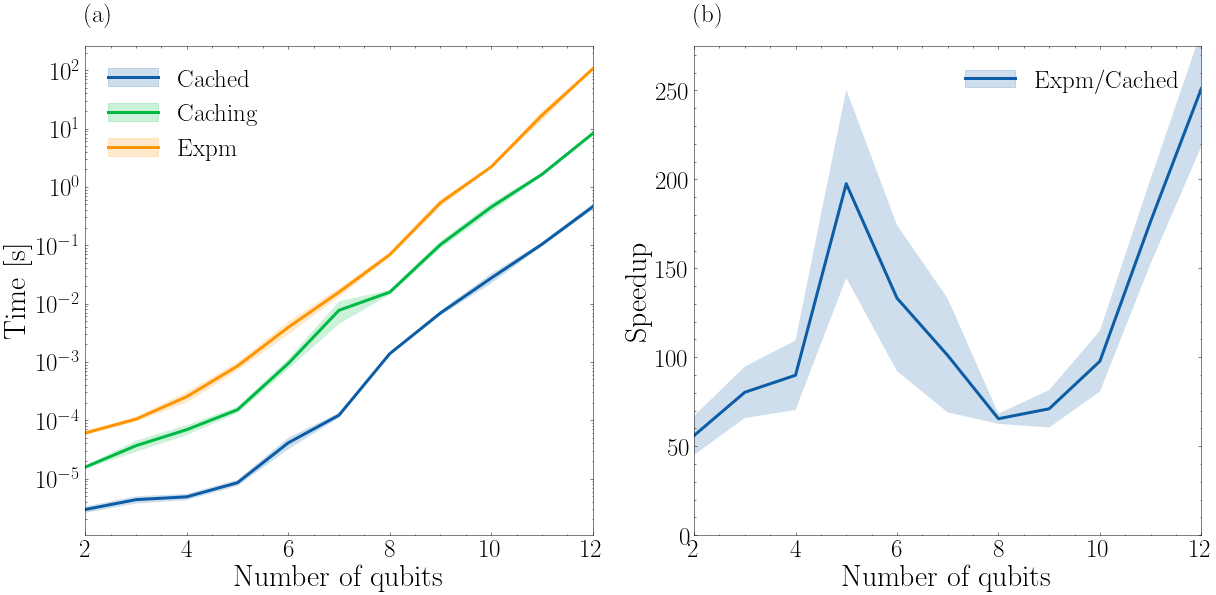

In [23]:
# Runtime plots for gates
fn_gates = os.path.join("plots_paper", "ms_execution_times_n_max_12.pkl")
from iplots import *
from cycler import cycler
import matplotlib.pyplot as plt
import pickle
n_max = 12

with open(fn_gates, 'rb') as f:
    times, speedups = pickle.load(f)

SMALL_SIZE = 10
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.style.use("science")
alphas = np.array([0.2])
plt.rc('lines', linewidth=3)
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the mean times and the standard deviations via fill_in_between, and the speedups via semilogy in a separated plot
# Create 2 vertically stacked plots with different heights
fig, axes = plt.subplots(1, 2, figsize=(20,9))
axs, ax = axes

for i_a, a in enumerate(axes):
        a.text(0.0, 1.05, "(" + string.ascii_lowercase[i_a] + ")", transform=a.transAxes,
               size=MEDIUM_SIZE, weight='bold')

key_condition = lambda key: 'Multi' in key and 'Eig' not in key or 'Caching' in key
key_transform = lambda key: key.replace('Multi ', '').lstrip().rstrip()
# Plot times using std_plot
legendary = []
plot_keys_times = ["Cached", "Caching", "Expm"]
print(times)
for key in plot_keys_times:
    mean_vals, std_vals = times[key]
    curr_key = key_transform(key)
    legendary, mini = std_plot(axs, arange(2, n_max+1, dtype=float), mean_vals, std_vals, alphas=alphas, ps = 0.68, ns=1, label=curr_key, logy=True, legendary=legendary)

axs.set(xlabel='Number of qubits', ylabel='Time [s]', xlim=[2, n_max])
axs.legend(*legendary)

# Plot speedupsy
legendary = []
print(speedups.items())
plot_keys_speedup = ["Multi Expm/Multi Cached"]
for key in plot_keys_speedup:
    mean_vals, std_vals = speedups[key]
    curr_key = key_transform(key)
    legendary, mini = std_plot(ax, arange(2, n_max+1, dtype=float), mean_vals, std_vals, alphas=alphas, ps = 0.68, ns=1, label=curr_key, logy=False, legendary=legendary)

ax.set(xlabel='Number of qubits', ylabel='Speedup', xlim=[2, n_max], ylim=[0, 275])
ax.legend(*legendary)

plt.savefig("sim_gate_speedup.pdf", dpi=300,
            format='pdf',
            bbox_inches='tight')

[0.93439929 0.95436474 0.94772029 0.95244473 0.94908823]
4
0.9490882332209535
[11121 13689 10080  4439   459]
[3, 2, 2, 4, 5, 2, 1, 3, 2, 1, 5, 2, 2, 1, 3, 5, 1, 3, 4, 3, 4, 3, 2, 1, 3, 5, 1, 5, 3, 5, 3, 2, 4, 1, 4, 5, 2, 3, 2, 2, 4, 1, 4, 3, 2, 5, 3, 5, 4, 2, 5, 4, 2, 2, 1, 3, 2, 4, 2, 4, 1, 4, 5, 3, 2, 2, 2, 5, 3]
Constructing cost function...


/home/francesco/miniconda3/envs/torch-env/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3233: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


[GpuDevice(id=0, process_index=0)]
<CompiledFunction of <function pvqd_evo_cost.<locals>.cs_to_unitaries at 0x7f483b6e9e50>>
Constructing cost function...
[GpuDevice(id=0, process_index=0)]
<CompiledFunction of <function pvqd_evo_cost.<locals>.cs_to_unitaries at 0x7f483b6fa790>>
69 99 ['Zloc_1', 'Cxy', 'Cxy', 'Zloc_2', 'Zloc_3', 'Cxy', 'MS', 'Zloc_1', 'Cxy', 'MS', 'Zloc_3', 'Cxy', 'Cxy', 'MS', 'Zloc_1', 'Zloc_3', 'MS', 'Zloc_1', 'Zloc_2', 'Zloc_1', 'Zloc_2', 'Zloc_1', 'Cxy', 'MS', 'Zloc_1', 'Zloc_3', 'MS', 'Zloc_3', 'Zloc_1', 'Zloc_3', 'Zloc_1', 'Cxy', 'Zloc_2', 'MS', 'Zloc_2', 'Zloc_3', 'Cxy', 'Zloc_1', 'Cxy', 'Cxy', 'Zloc_2', 'MS', 'Zloc_2', 'Zloc_1', 'Cxy', 'Zloc_3', 'Zloc_1', 'Zloc_3', 'Zloc_2', 'Cxy', 'Zloc_3', 'Zloc_2', 'Cxy', 'Cxy', 'MS', 'Zloc_1', 'Cxy', 'Zloc_2', 'Cxy', 'Zloc_2', 'MS', 'Zloc_2', 'Zloc_3', 'Zloc_1', 'Cxy', 'Cxy', 'Cxy', 'Zloc_3', 'Zloc_1']


/home/francesco/miniconda3/envs/torch-env/lib/python3.8/site-packages/numpy_ringbuffer/__init__.py:22: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self._arr = np.empty(capacity, dtype)


(138,)
(138,)


ValueError: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array